# Batch images processing

## Inputs

In [1]:
# Import libraries
from calibrations import  build_calibration, calibrate_color_and_distortion, calibrate_color
import os
import pickle
import shutil
import pandas as pd
from aux_functions import slicing, obtain_pixel_metric, divide_in_sets, ungroup_pic, prepare_pose_dataset
from model_class import model_segmentation
from pictures_class import pictures
from morphometrics_functions import install_morphometrics_packages_r, exploratory_morphometrics_r, run_efourier_pca_morphometrics_r, run_plot_pca_morphometrics_r, run_kmeans_efourier_r, run_obtain_kmeans_classification_r
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
#Inputs
working_directory="C:/Users/Pheno/Documents/database_almondcv2/"
raw_folder=r"C:\Users\Pheno\Documents\database_almondcv2\2023\sessions_laboratory\Seleccionadas"
chessboards="C:/Users/Pheno/Documents/database_almondcv2/calibracion/chessboards"
mtx_input_path=os.path.join(chessboards,"calibration_mtx.npz") ## for distorsion
standard_matrix_color=r"C:\Users\Pheno\Documents\database_almondcv2\2023\sessions_laboratory\Seleccionadas\RGB_SEED_13_06_22cm_muestras_2_2024-06-13-13-45-31_2.jpg" ### a picture to select if some pictures produces errors in color 
info_data_2022="C:/Users/Pheno/Documents/database_almondcv2/info_data.txt"
info_data_2023="C:/Users/Pheno/Documents/database_almondcv2/info_data_2023.txt"
info_data_lab_2023="C:/Users/Pheno/Documents/database_almondcv2/info_data_completed_2023_session_lab"
zip_file_coin=os.path.join(working_directory,"coin_640_slices_2023set.zip")
zip_file_group=os.path.join(working_directory,"rectangles_set_2023_shell.zip")
zip_file_shell=os.path.join(working_directory,"shell_2022_320.zip")
zip_file_seed=os.path.join(working_directory,"seed_2023_2025_160px.zip")


models_directory="C:/Users/Pheno/Documents/database_almondcv2/models/"
pre_model=os.path.join(models_directory, "yolo11s-seg.pt")

coin_model_path=os.path.join(models_directory,"coin_2023_yolov11s_640.pt")

group_model_path_1=os.path.join(models_directory, "rectangles_shell_2023_imgsize_1280.pt")
group_model_path_2=os.path.join(models_directory, "rectangles_seed_2023_imgsz_1600.pt")
group_model_path_2022="rectangle_2022_yolov11s_1280.pt"

shell_model_path=os.path.join(models_directory, "shell_2022_yolov11s_320.pt")
seed_model_path=os.path.join(models_directory, "seed_2022_yolov11s_320.pt")

shell_model_path_2023=os.path.join(models_directory, "shell_2023_yolov11s_320.pt")
seed_model_path_2023=os.path.join(models_directory, "seed_2023_yolov11s_320.pt")



#outputs
output="C:/Users/Pheno/Documents/database_almondcv2"
output_calibrated=os.path.join(output,"calibrated_pics_2023_laboratory/")
os.makedirs(output_calibrated, exist_ok=True)

## Color and distorsion correction

In [ ]:
# If you need to create distortion model
build_calibration(chessboardSize=(6, 8), frameSize=(5472,3648), dir_path=chessboards, 
                  image_format=".jpg", size_of_chessboard_squares_mm=20)

In [ ]:
#Ahora mismo esta puesto en modo calibracion los errores utilizando una foto como referencia, para calibracion normal quitar la standard_matrix_color
calibrate_color_and_distortion(raw_folder=raw_folder,mtx_input_path=mtx_input_path,output_calibrated=output_calibrated,
                                radius_param=10, standard_matrix=standard_matrix_color)

In [ ]:
#Si solo quieres hacer color esta la función

# calibrate_color(input_folder=raw_folder, output_path=output_calibrated,standard_matrix=standard_matrix_color)
calibrate_color(input_folder=raw_folder, output_path=output_calibrated,standard_matrix=standard_matrix_color,
                 force_standard_matrix="Yes")

In [ ]:
#CHUNK para mover automaticamente lo que este en la lista errores a donde tu queiras
#first we move 

carpeta_destino = os.path.join(raw_folder,"errores")    # Cambia esto por la ruta correcta

# Crea la carpeta de destino si no existe
os.makedirs(carpeta_destino, exist_ok=True)


# Lee el archivo de texto con los nombres de las imágenes
with open(os.path.join(output_calibrated,"errors_in_calibrations.txt"), "r") as archivo:
    for nombre_imagen in archivo:
        nombre_imagen = nombre_imagen.strip()  # Elimina espacios en blanco y saltos de línea
        ruta_imagen_origen = os.path.join(raw_folder, nombre_imagen)
        
        # Verifica si el archivo existe antes de moverlo
        if os.path.exists(ruta_imagen_origen):
            # Mueve la imagen a la carpeta de destino
            shutil.copy(ruta_imagen_origen, carpeta_destino)
            print(f"Moviendo: {nombre_imagen} a {carpeta_destino}")
        else:
            print(f"No se encontró la imagen: {nombre_imagen}")

## Load info data

In [ ]:
#Cargar info_data, se puede cargar ya una columna pixelmetric con la informacion pixel-mm o obtener la metrica pixel desde las imagenes.
info_data_df=pd.read_csv(info_data_lab_2023,sep="\t")
# Si las hemos calibrado añadimos CL delante
info_data_df['Name_picture'] = info_data_df['Name_picture'].apply(lambda x: 'CL_' + x)
info_data_df

### Obtain pixel_metric from the pictures

In [ ]:
# Si no tienes un modelo para reconocer tu objeto de referencia debes crearlo
#Se comienza haciendo particiones de la imagen con la función slicing para introducirlas en CVAT

slicing(input_folder=output_calibrated,output_directory=working_directory,
        name_slicing="gsgsg", number_pictures=60,
          crop="left", slice_height=640, slice_width=640, overlap_height_ratio=0.2, overlap_width_ratio=0.2, crop_level=2)


In [ ]:
# Posteriormente se tiene que segmentar en CVAT, y ese output se leera para entrenar el modelo y ver si funciona bien, para ello utilizamos la función
# train model, pon el archivo.zip en el working directory.

coin_model=model_segmentation(working_directory=working_directory)
coin_model.train_segmentation_model(input_zip=zip_file_coin, epochs=80,imgsz=640,
                                     name_segmentation="coin_640px_slices640_26102024_set2023_retina", pre_model=pre_model
                                     , batch=16)

In [ ]:
# Si tenemos el modelo ya simplemente podemos cargarlo y aplicarlo sobre la carpeta que queramos

coin_model_saved=model_segmentation(working_directory=working_directory)
contours_coin=coin_model_saved.slice_predict_reconstruct(input_folder=output_calibrated, imgsz=640,
                                                         model_path=coin_model_path, slice_height=640, slice_width=640,
                                                         overlap_height_ratio=0.2, overlap_width_ratio=0.2,
                                                           retina_mask=True)




In [15]:
info_data_completed=obtain_pixel_metric(info_data=info_data_df, contours=contours_coin,
                                         output_directory=working_directory, reference=24.25)

In [ ]:
info_data_completed

### Desagrupar imagenes

In [ ]:
# Una vez hemos completado ya el pixelmetric, si tenemos fotos agrupadas, debemos desagruparlas y conectarlas con su ID
#Para posteriormente sacar las medidas que queramos. Esta vez no hacemos slicing, peusto que los grupos son mas grandes que las slcies.
# divide_in_sets(input_folder=output_calibrated,output_directory=working_directory, division_name="rectangle_group_2023", number_pictures=100)

#Esta vez hacemos solo shell
folder_shell=os.path.join(working_directory, "")
divide_in_sets(input_folder=folder_shell,output_directory=working_directory, division_name="", number_pictures=60)

In [ ]:
#Ahora vamos a entrenar un modelo para que reconozca los grupos

group_model=model_segmentation(working_directory=working_directory)
group_model.train_segmentation_model(input_zip=zip_file_group, epochs=80,imgsz=1280,
                                      name_segmentation="rectangle_group_2023set_shell", pre_model=pre_model, batch=6)

In [ ]:
#ESTO DESPUES PARA LOS CONTORNOS EN GROUPED PICTURES

# Si tenemos el modelo ya simplemente podemos cargarlo y aplicarlo sobre la carpeta que queramos
#Esta funcion se puede optimizar, cuando hay muchas fotos se llena la RAM y va mas lento a partir de las 300 fotos.Habría que hacer tandas, lo que lo peta es la retina mask. 
group_model_saved=model_segmentation(working_directory=working_directory)
contours_groups=group_model_saved.predict_model(model_path=group_model_path_2,
                               folder_input=os.path.join(working_directory, "ROTAR"),
                               imgsz=1600, check_result=False, max_det=2, retina_mask=False)

In [ ]:
#Ahora que ya tenemos los contornos, podemos aplicarlo a nuestras imagenes, y tambien coordinaar el info_data_df
info_data_completed_path=os.path.join(working_directory, "info_data_completed_2023.txt")
info_data_completed=pd.read_csv(info_data_completed_path,sep="\t")
#PARA QUE FUNCIONE EN 2023 EDITAR EL INFO DATA EN donde pone Sample number cambiar los 0 por 1.
info_data_completed.loc[info_data_completed['Sample_number'] == 0, 'Sample_number'] = 1


ungroup_pic(input_contours=contours_groups, output_path=working_directory, info_file=info_data_completed, axis="Y")

## Measuring

### Shell Almonds

In [3]:
#Vamos a entrenar un modelo para las almendras con cascara
#Vamos a separar en una carpeta las imagenes de almendras con cascara
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]

# Directorio donde están las imágenes
directorio_imagenes = f"{working_directory}/Ungrouped_pics"  # Cambia esto por la ruta correcta
# Directorio de destino donde copiarás las imágenes
directorio_destino = f"{working_directory}/Shell_ungrouped_pics"

# Crear el directorio de destino si no existe
os.makedirs(directorio_destino, exist_ok=True)

# Copiar las imágenes
for index, row in info_data_df.iterrows():
    imagen_relativa = row['Sample_picture']  # Obtener la ruta relativa de la imagen
    imagen_path = os.path.join(directorio_imagenes, imagen_relativa)  # Ruta completa

    try:
        # Copiar la imagen al directorio de destino
        shutil.copy(imagen_path, os.path.join(directorio_destino, os.path.basename(imagen_path)))
        print(f"Imagen copiada: {imagen_path} a {directorio_destino}")
    except Exception as e:
        print(f"No se pudo copiar la imagen {imagen_path}. Error: {e}")

In [ ]:
#Bien ahora vamos a hacer el slicing y a segmentar y etiquetar las imagenes

directorio_imagenes=os.path.join(working_directory, "Ungrouped_pics_shell_2023")


slicing(input_folder=directorio_imagenes,output_directory=working_directory,name_slicing="Slices_for_shell_2023_29102024_320", number_pictures=50, slice_height=320, slice_width=320)

In [ ]:
#Ahora vamos a entrenar el modelo 

shell_model=model_segmentation(working_directory=working_directory)
shell_model.train_segmentation_model(input_zip=zip_file_shell, epochs=100,imgsz=640, name_segmentation="shell_2022_yolov11",
                                      pre_model=pre_model, batch=16)


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con watershed


info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "Shell_ungrouped_pics")
shell_masks=model_segmentation(working_directory=working_directory)

shell_masks=shell_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=320, model_path=shell_model_path,
                                          slice_height=320, slice_width=320,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="Shell_2022_07012025_watershed", blurring_binary_masks=False)
shell_object.set_postsegmentation_parameters(sahi=False, segmentation_input=shell_masks, smoothing=False, smoothing_iterations=2, kernel_smoothing=3,
                        watershed=True, kernel_watershed=5, threshold_watershed=0.6)
shell_object.measure_almonds(margin=400)

# Guardar el objeto en un archivo
with open('shell_object_2022_watershed.pkl', 'wb') as archivo:
    pickle.dump(shell_object, archivo)

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con watershed


info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_shell2023.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "Ungrouped_pics_shell_2023")
shell_masks=model_segmentation(working_directory=working_directory)

shell_masks=shell_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=320, model_path=shell_model_path_2023,
                                          slice_height=320, slice_width=320,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="Shell_2023_07012025_watershed", blurring_binary_masks=False)
shell_object.set_postsegmentation_parameters(sahi=False, segmentation_input=shell_masks, smoothing=False, smoothing_iterations=2, kernel_smoothing=3,
                        watershed=True, kernel_watershed=5, threshold_watershed=0.6)
shell_object.measure_almonds(margin=400)

# Guardar el objeto en un archivo
with open('shell_object_2023_watershed.pkl', 'wb') as archivo:
    pickle.dump(shell_object, archivo)

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con sahi
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "Shell_ungrouped_pics")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.2,
                                                overlap_width_ratio=0.2, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.95,
                                                  imgsz=320)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="Shell_2022_07012025_sahi",  blurring_binary_masks=False)
shell_object.set_postsegmentation_parameters(sahi=True, segmentation_input=shell_masks)
shell_object.measure_almonds(margin=400)

# Guardar el objeto en un archivo
with open('shell_object_2022_sahi.pkl', 'wb') as archivo:
    pickle.dump(shell_object, archivo)


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con sahi

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_shell2023.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "Ungrouped_pics_shell_2023")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path_2023, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.2,
                                                overlap_width_ratio=0.2, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.95,
                                                  imgsz=320)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="Shell_2023_07012025_sahi",  blurring_binary_masks=False)
shell_object.set_postsegmentation_parameters(sahi=True, segmentation_input=shell_masks)
shell_object.measure_almonds(margin=400)

# Guardar el objeto en un archivo
with open('shell_object_2023_sahi.pkl', 'wb') as archivo:
    pickle.dump(shell_object, archivo)


In [ ]:
#si queremos borrar ourliers y errores
outlier_f=f"{working_directory}/Results_Shell_2023_10122024_watershed_parte2/outlier_table.txt"
shell_object.correct_outliers(outlier_file=outlier_f)

### Seed Almonds

In [ ]:
#Vamos a entrenar un modelo para las almendras sin cascara
#Vamos a separar en una carpeta las imagenes de almendras sin cascara
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]

# Directorio donde están las imágenes
directorio_imagenes = f"{working_directory}/Ungrouped_pics"  # Cambia esto por la ruta correcta
# Directorio de destino donde copiarás las imágenes
directorio_destino = f"{working_directory}/Seed_ungrouped_pics"

# Crear el directorio de destino si no existe
os.makedirs(directorio_destino, exist_ok=True)

# Copiar las imágenes
for index, row in info_data_df.iterrows():
    imagen_relativa = row['Sample_picture']  # Obtener la ruta relativa de la imagen
    imagen_path = os.path.join(directorio_imagenes, imagen_relativa)  # Ruta completa

    try:
        # Copiar la imagen al directorio de destino
        shutil.copy(imagen_path, os.path.join(directorio_destino, os.path.basename(imagen_path)))
        print(f"Imagen copiada: {imagen_path} a {directorio_destino}")
    except Exception as e:
        print(f"No se pudo copiar la imagen {imagen_path}. Error: {e}")

In [ ]:
directorio_destino = f"{working_directory}/Ungrouped_clean_seed_2023"
slicing(input_folder=directorio_destino,output_directory=working_directory,name_slicing="Slices_for_seed_08012025_160_2023", number_pictures=30, slice_height=160, slice_width=160)

In [ ]:
seed_model=model_segmentation(working_directory=working_directory)
seed_model.train_segmentation_model(input_zip=zip_file_seed, epochs=100,imgsz=160, name_segmentation="seed_2023_08012025_px",
                                      pre_model=pre_model, batch=16)

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con watershed


info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]
input_folder=os.path.join(working_directory, "Seed_ungrouped_pics_2022")
seed_masks=model_segmentation(working_directory=working_directory)

seed_masks=seed_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=320, model_path=seed_model_path,
                                          slice_height=320, slice_width=320,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2)
seed_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Seed_almond", binary_masks=True, project_name="Seed_2022_07012025_watershed",  blurring_binary_masks=False)
seed_object.set_postsegmentation_parameters(sahi=False, segmentation_input=seed_masks, smoothing=True, smoothing_iterations=2, kernel_smoothing=3,
                        watershed=True, kernel_watershed=5, threshold_watershed=0.6)
seed_object.measure_almonds(margin=150)


# Guardar el objeto en un archivo
with open('seed_object_2022_watershed.pkl', 'wb') as archivo:
    pickle.dump(seed_object, archivo)


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con watershed


info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_2023_session_lab.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]
input_folder=os.path.join(working_directory, "Ungrouped_2023_seed_session_lab")
# input_folder=os.path.join(working_directory, "fotos_prueba")
seed_masks=model_segmentation(working_directory=working_directory)

seed_masks=seed_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=320, model_path=seed_model_path_2023,
                                          slice_height=320, slice_width=320,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2)
seed_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Seed_almond", binary_masks=True, project_name="Seed_2023_14012025_watershed_smooth_sesionlab",  blurring_binary_masks=True, binary_pixel_size=250, blur_binary_masks_value=15)
seed_object.set_postsegmentation_parameters(sahi=False, segmentation_input=seed_masks, smoothing=True, smoothing_iterations=2, kernel_smoothing=3,
                        watershed=True, kernel_watershed=5, threshold_watershed=0.6)
seed_object.measure_almonds(margin=150)

# Guardar el objeto en un archivo
with open('seed_object_2023_watershed_sesionlab.pkl', 'wb') as archivo:
    pickle.dump(seed_object, archivo)



In [ ]:
#si queremos borrar ourliers y errores
outlier_f=f"{working_directory}/Results_Seed_2023_10122024_watershed/outlier_table.txt"
seed_object.correct_outliers(outlier_file=outlier_f)

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con sahi

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]
input_folder=os.path.join(working_directory, "Seed_ungrouped_pics_2022")
seed_masks=model_segmentation(working_directory=working_directory)
seed_masks=seed_masks.predict_model_sahi(model_path=seed_model_path, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.3,
                                                overlap_width_ratio=0.3, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.95,
                                                  imgsz=320)
seed_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Seed_almond", binary_masks=False, project_name="Seed_2022_07012025_sahi" , blurring_binary_masks=False)
seed_object.set_postsegmentation_parameters(sahi=True, segmentation_input=seed_masks)
seed_object.measure_almonds()


# Guardar el objeto en un archivo
with open('seed object_2022_sahi.pkl', 'wb') as archivo:
    pickle.dump(seed_object, archivo)


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con sahi

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_2023_session_lab.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]
input_folder=os.path.join(working_directory, "fotos_prueba")
seed_masks=model_segmentation(working_directory=working_directory)
seed_masks=seed_masks.predict_model_sahi(model_path=seed_model_path_2023, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.9, overlap_height_ratio=0.2,
                                                overlap_width_ratio=0.2, postprocess_match_metric="IOS", 
                                                postprocess_type="NMS", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.9,
                                                  imgsz=320)
seed_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Seed_almond", binary_masks=True, project_name="Seed_2023_14012025_sahi_smooth_sesionlab" , blurring_binary_masks=False, blur_binary_masks_value=15)
seed_object.set_postsegmentation_parameters(sahi=True, segmentation_input=seed_masks)
seed_object.measure_almonds()


# Guardar el objeto en un archivo
with open('seed object_2023_sahi.pkl', 'wb') as archivo:
    pickle.dump(seed_object, archivo)


## Outliers and errors

In [ ]:
#si queremos borrar ourliers y errores
outlier_f=f"{working_directory}/Results_Seed_2023_14012025_watershed_smooth_sesionlab/outlier_real.txt"
add_f=f"{working_directory}/Results_Seed_2023_14012025_watershed_smooth_sesionlab/add.txt"
# Cargar el archivo previamente guardado
with open(f'{working_directory}/BACKUPS_Resultados_postnavidad/seed_object_2023_watershed_sesionlab.pkl', 'rb') as archivo:
    dataset_object = pickle.load(archivo)


dataset_object.correct_outliers(outlier_file=outlier_f, addingsamples_file=add_f)

In [ ]:
dataset_object.morphology_table.Fruit_number[0]

## Morphometrics

In [2]:

input_masks=r"C:\Users\Pheno\Documents\database_almondcv2\BACKUPS_Resultados_postnavidad\clean\Binary_masks_shell"
working_directory=r"C:\Users\Pheno\Documents\database_almondcv2\MORPHOMETRICS"
# input_masks=r"C:\Users\Pheno\Documents\database_almondcv2\pruebas_binary"
# input_masks=r"C:\Users\Pheno\Downloads\Images (1)\Images\ReSized"

# info_data_masks=r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2022_09122024_watershed\binary_masks_info_table.txt"

In [ ]:
#binary masks outlier detection

import os
from PIL import Image
import numpy as np

# Definir la ruta de la carpeta con las imágenes
directorio_imagenes = input_masks

# Definir el tamaño del cuadrado central y el umbral para los píxeles blancos
tamano_cuadrado = 75  # 50x50 píxeles
umbral_blanco = 255  # Valor para los píxeles blancos en una imagen binaria (0-255)

# Lista para almacenar los nombres de las imágenes que contienen píxeles blancos en el centro
imagenes_con_blanco = []

# Recorrer todas las imágenes en la carpeta
for archivo in os.listdir(directorio_imagenes):
    if archivo.endswith(('.png', '.jpg', '.jpeg')):  # Solo imágenes de estos tipos
        # Cargar la imagen
        ruta_imagen = os.path.join(directorio_imagenes, archivo)
        imagen = Image.open(ruta_imagen).convert('L')  # Convertir a escala de grises

        # Convertir la imagen a un array numpy
        imagen_array = np.array(imagen)

        # Obtener el centro de la imagen (cuadrado de 50x50)
        alto, ancho = imagen_array.shape
        centro_x, centro_y = ancho // 2, alto // 2
        cuadrado_centro = imagen_array[centro_y - tamano_cuadrado // 2: centro_y + tamano_cuadrado // 2,
                                       centro_x - tamano_cuadrado // 2: centro_x + tamano_cuadrado // 2]

        # Verificar si hay píxeles blancos en el cuadrado central
        if np.any(cuadrado_centro == umbral_blanco):  # Si algún píxel en la región es blanco
            imagenes_con_blanco.append(archivo)

# Mostrar los resultados
if imagenes_con_blanco:
    print("Las siguientes imágenes contienen píxeles blancos en el centro:")
    for imagen in imagenes_con_blanco:
        print(imagen)
else:
    print("No se encontraron imágenes con píxeles blancos en el centro.")


### Momocs

In [ ]:
# Primero hay que ejecutar un script para instalar las librerías necesarias
install_morphometrics_packages_r()

Salida del comando R:
El archivo info_data no es vÃ¡lido o estÃ¡ vacÃ­o. Se omitirÃ¡ el uso de esta variable.
[ 1 / 21315 ]  CL_02_11_F-004_1.png_1.jpg
[ 2 / 21315 ]  CL_02_11_F-004_1.png_10.jpg
[ 3 / 21315 ]  CL_02_11_F-004_1.png_11.jpg
[ 4 / 21315 ]  CL_02_11_F-004_1.png_12.jpg
[ 5 / 21315 ]  CL_02_11_F-004_1.png_13.jpg
[ 6 / 21315 ]  CL_02_11_F-004_1.png_14.jpg
[ 7 / 21315 ]  CL_02_11_F-004_1.png_15.jpg
[ 8 / 21315 ]  CL_02_11_F-004_1.png_16.jpg
[ 9 / 21315 ]  CL_02_11_F-004_1.png_17.jpg
[ 10 / 21315 ]  CL_02_11_F-004_1.png_18.jpg
[ 11 / 21315 ]  CL_02_11_F-004_1.png_19.jpg
[ 12 / 21315 ]  CL_02_11_F-004_1.png_2.jpg
[ 13 / 21315 ]  CL_02_11_F-004_1.png_20.jpg
[ 14 / 21315 ]  CL_02_11_F-004_1.png_3.jpg
[ 15 / 21315 ]  CL_02_11_F-004_1.png_4.jpg
[ 16 / 21315 ]  CL_02_11_F-004_1.png_5.jpg
[ 17 / 21315 ]  CL_02_11_F-004_1.png_6.jpg
[ 18 / 21315 ]  CL_02_11_F-004_1.png_7.jpg
[ 19 / 21315 ]  CL_02_11_F-004_1.png_8.jpg
[ 20 / 21315 ]  CL_02_11_F-004_1.png_9.jpg
[ 21 / 21315 ]  CL_02_11_F-0

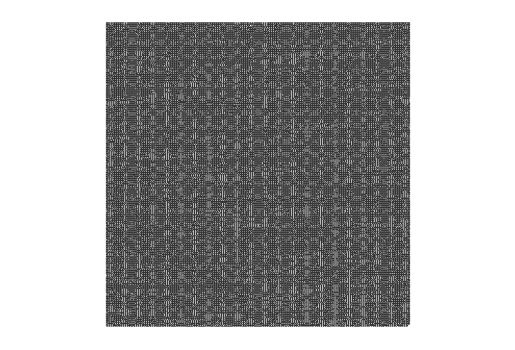

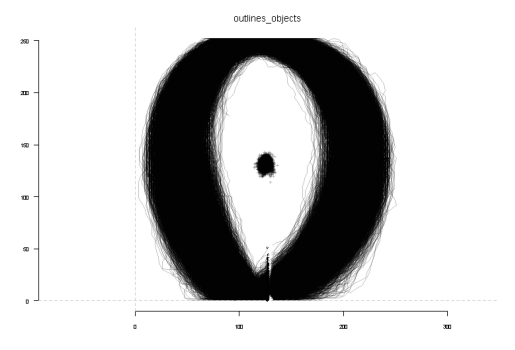

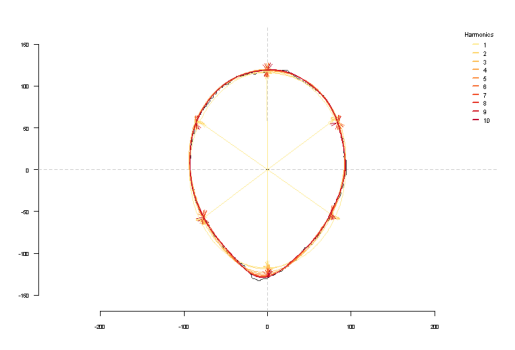

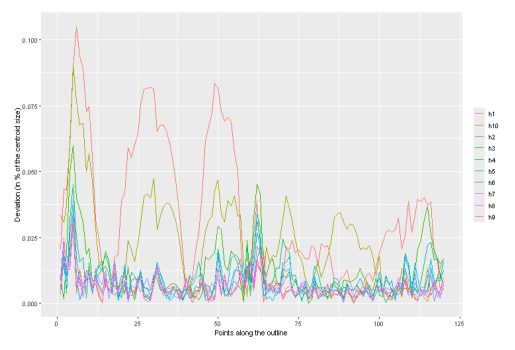

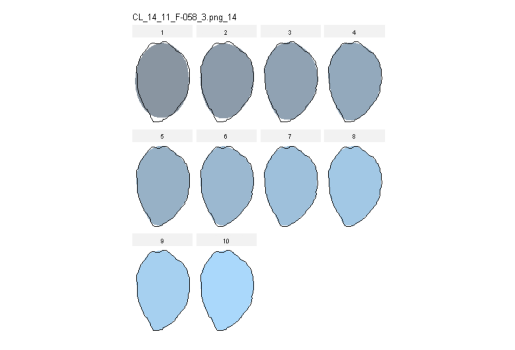

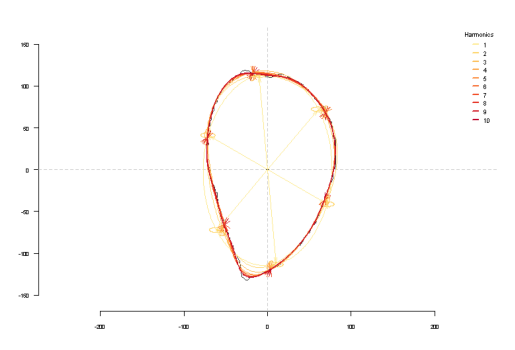

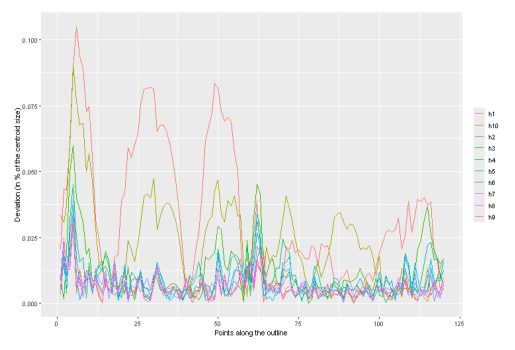

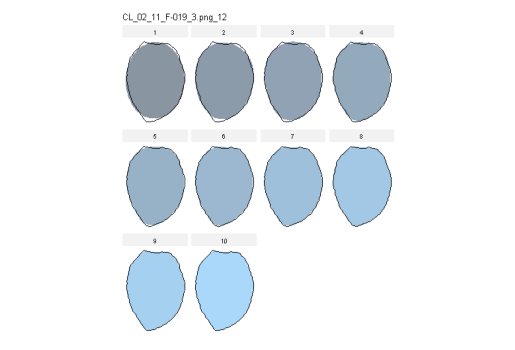

In [3]:
# #Analisis exploratorio para decidir nharmonics
# exploratory_morphometrics_r(info_data=info_data_masks, grouping_factor="", directorio_input=input_masks,
#                              output_directory=working_directory, show=True, nharmonics=10,nexamples=2)

exploratory_morphometrics_r(info_data="", grouping_factor="", directorio_input=input_masks,
                             output_directory=working_directory, show=True, nharmonics=10,nexamples=2)

Salida del comando R:
null device 
          1 
null device 
          1 

Error:

Adjuntando el paquete: 'Momocs'

The following object is masked from 'package:stats':

    filter

Aviso:
package 'Momocs' was built under R version 4.4.2 



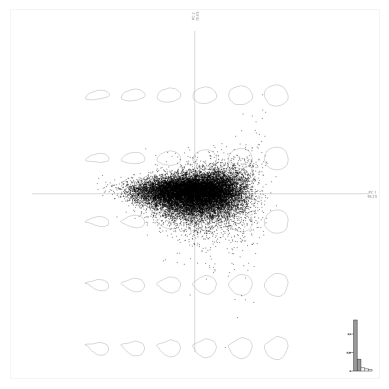

In [4]:
ruta=os.path.join(working_directory,"exploratory_plots","outlines_objects.rds")
run_efourier_pca_morphometrics_r(ruta_outline_objects=ruta, nharmonics=10, output_directory=working_directory,
                                  show=True, normalize="False", img_height_pca=1000, img_width_pca=1000)

In [ ]:
ruta=os.path.join(working_directory,"efourier_results","pca_fourier.rds")
# run_plot_pca_morphometrics_r(ruta_pca_objects=ruta, output_directory=working_directory, grouping_factor="ID", chull_layer="TRUE", chullfilled_layer="TRUE")
run_plot_pca_morphometrics_r(ruta_pca_objects=ruta, output_directory=working_directory, PC_axis1="1", PC_axis2="4", img_height_pca=1000, img_width_pca=1000)

In [ ]:
ruta=os.path.join(working_directory,"efourier_results","pca_fourier.rds")
run_kmeans_efourier_r(ruta_pca_objects=ruta, output_directory=working_directory,max_clusters=10, img_height_pca=1000, img_width_pca=1000, plot_xlim=250, plot_ylim=250)

In [ ]:
ruta_1=os.path.join(working_directory,"efourier_results","pca_fourier.rds")
ruta_2=os.path.join(working_directory,"kmeans_results","kmeans_pca_fourier_5.rds")
run_obtain_kmeans_classification_r(ruta_pca_objects=ruta_1, output_directory=working_directory, ruta_kmeans_objects=ruta_2,
                                   chull_layer="TRUE", chullfilled_layer="TRUE")

### PCA

In [ ]:


# Definir el directorio donde están las imágenes
directorio_imagenes = r'C:\Users\Pheno\Documents\database_almondcv2\BACKUPS_Resultados_postnavidad\clean\Binary_masks_seed'  # Actualiza esta ruta

# Obtener la lista de archivos en el directorio
archivos_imagenes = [f for f in os.listdir(directorio_imagenes) if f.endswith(('.png', '.jpg'))]

# Cargar las imágenes
imagenes = []
for archivo in archivos_imagenes:
    ruta_imagen = os.path.join(directorio_imagenes, archivo)
    imagen = Image.open(ruta_imagen).convert('1')  # Convertir a escala binaria
    imagen_array = np.array(imagen)  # Convertir la imagen a un array numpy
    imagen_array = np.invert(imagen_array)
    imagenes.append(imagen_array)

# Convertir la lista de imágenes a una matriz de tamaño (k, m*n)
# Donde k es el número de imágenes y m*n es el número total de píxeles por imagen
imagenes = np.array(imagenes)
imagenes_aplanadas = imagenes.reshape(imagenes.shape[0], -1)  # Aplanar las imágenes

print("Matriz de imágenes aplanadas:", imagenes_aplanadas.shape)


In [ ]:
# Realizar PCA para reducir la dimensionalidad
pca = PCA(n_components=50)  # Reducir a 50 componentes principales
imagenes_pca = pca.fit_transform(imagenes_aplanadas)

# Mostrar la varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_

# Crear un DataFrame con los valores de PCA
df_pca = pd.DataFrame(
    imagenes_pca[:, :10],  # Tomar solo las primeras 10 componentes principales
    columns=[f"PC{i+1}" for i in range(10)],  # Nombres de las columnas (PC1 a PC10)
    index=archivos_imagenes  # Usar los nombres reales de las imágenes como índice
)

# Guardar el DataFrame con los valores de PCA en un archivo TXT
archivo_salida_pca = os.path.join(working_directory,"valores_pca.txt")
df_pca.to_csv(archivo_salida_pca, sep="\t", index=True)
print(f"Archivo de valores PCA guardado como {archivo_salida_pca}")

# Guardar la varianza explicada en otro archivo TXT
archivo_salida_varianza = os.path.join(working_directory,"varianza_explicada.txt")
with open(archivo_salida_varianza, "w") as f:
    f.write("Componente Principal\tVarianza Explicada\n")
    for i, var in enumerate(varianza_explicada, 1):
        f.write(f"PC{i}\t{var:.6f}\n")

print(f"Archivo de varianza explicada guardado como {archivo_salida_varianza}")

In [ ]:
# Evaluar KMeans para diferentes valores de k (1 a 20)
distorsiones = []  # Para almacenar la inercia para cada k
for k in range(1, 10):  # Cambié el rango para evaluar hasta k=20
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(imagenes_pca)
    distorsiones.append(kmeans.inertia_)

    # Paso 3: Visualizar los centroides de cada clúster
    centroides_pca = kmeans.cluster_centers_

    # Proyectar los centroides de nuevo al espacio original
    centroides_original = pca.inverse_transform(centroides_pca)

    # Paso 4: Visualización de centroides con un tamaño adecuado
    # Calculamos el número de filas y columnas
    filas = (k + 4) // 5  # Determinamos cuántas filas serán necesarias
    columnas = min(k, 5)  # Limitar a 5 columnas por fila (máximo)

    plt.figure(figsize=(15, 3 * filas))  # Tamaño de la figura ajustado a las filas

    for i, centroide in enumerate(centroides_original):
        # Convertir el centroide (vector) a una imagen binaria
        imagen_binaria = centroide.reshape(imagenes.shape[1], imagenes.shape[2]) > 0.5  # Umbral para binarizar

        # Crear una subgráfica
        ax = plt.subplot(filas, columnas, i + 1)
        ax.imshow(imagen_binaria, cmap="Wistia")  # Usar un colormap marrón (copper)
        ax.set_title(f'Centroid {i + 1}')
        ax.axis('off')

    # Guardar la imagen de los centroides como un archivo JPG
    plt.tight_layout()
    plt.savefig(os.path.join(working_directory,f"centroides_k_{k}.jpg"), format="jpg")  # Guardar como JPG
    plt.show()

# Paso 5: Evaluar el número óptimo de clusters usando el gráfico del codo
plt.plot(range(1, 10), distorsiones, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Distorsión)')
plt.title('Método del Codo para seleccionar k')
plt.savefig(os.path.join(working_directory,f"elbow_plot.jpg"), format="jpg")  # Guardar como JPG
plt.show()

In [ ]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

# Evaluar KMeans para diferentes valores de k (1 a 10)
distorsiones = []  # Para almacenar la inercia para cada k
for k in range(1, 11):  # Cambié el rango para evaluar hasta k=10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(imagenes_pca)
    distorsiones.append(kmeans.inertia_)

    # Paso 3: Visualizar los centroides de cada clúster
    centroides_pca = kmeans.cluster_centers_

    # Proyectar los centroides de nuevo al espacio original
    centroides_original = pca.inverse_transform(centroides_pca)

    # Paso 4: Visualización de centroides en una sola fila
    columnas = k  # Número de centroides es igual al número de columnas
    filas = 1  # Solo una fila para todos los centroides

    # Fijar la altura a 8 cm (convertido a pulgadas) y dejar el ancho dinámico
    altura_cm = 8
    altura_inch = altura_cm / 2.54  # Convertir cm a pulgadas
    ancho_inch = 3 * columnas  # Ancho: 3 pulgadas por cada centroide

    # Ajustar el tamaño de la figura con las dimensiones en pulgadas
    plt.figure(figsize=(ancho_inch, altura_inch))  # Mantener altura fija y ajustar el ancho

    for i, centroide in enumerate(centroides_original):
        # Convertir el centroide (vector) a una imagen binaria
        imagen_binaria = centroide.reshape(imagenes.shape[1], imagenes.shape[2]) > 0.5  # Umbral para binarizar

        # Crear una subgráfica (una columna por centroide)
        ax = plt.subplot(1, columnas, i + 1)
        ax.imshow(imagen_binaria, cmap="Wistia")  # Usar un colormap marrón (copper)
        ax.set_title(f'Centroid {i + 1}')
        ax.axis('off')

    # Guardar la imagen de los centroides como un archivo JPG
    plt.tight_layout()
    plt.savefig(os.path.join(working_directory, f"centroides_k_{k}.jpg"), format="jpg")  # Guardar como JPG
    plt.show()

# Paso 5: Evaluar el número óptimo de clusters usando el gráfico del codo
plt.plot(range(1, 11), distorsiones, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Distorsión)')
plt.title('Método del Codo para seleccionar k')
plt.savefig(os.path.join(working_directory, "elbow_plot.jpg"), format="jpg")  # Guardar como JPG
plt.show()



In [ ]:
# Calcular la forma media en el espacio original
forma_media = pca.mean_.reshape(imagenes.shape[1], imagenes.shape[2])

# Para cada componente principal (PC1 a PC10)
for pc in range(10):  # Iterar por los primeros 10 PCs
    std_pc = np.sqrt(pca.explained_variance_[pc])  # Desviación estándar del componente
    direccion_pc = pca.components_[pc].reshape(imagenes.shape[1], imagenes.shape[2])  # Dirección del PC en el espacio original

    # Calcular las imágenes de la forma media ajustadas
    forma_pos = forma_media + 2 * std_pc * direccion_pc  # Media + 1.5*std
    forma_neg = forma_media - 2 * std_pc * direccion_pc  # Media - 1.5*std

    # Crear una figura con 3 imágenes: (-1.5 std, media, +1.5 std)
    plt.figure(figsize=(12, 4))

    # Forma media - 1.5 std
    plt.subplot(1, 3, 1)
    plt.imshow(forma_neg > 0.5, cmap="Wistia")  # Umbral para binarizar
    plt.title(f"PC{pc+1}: Media - 1.5*std")
    plt.axis("off")

    # Forma media
    plt.subplot(1, 3, 2)
    plt.imshow(forma_media > 0.5, cmap="Wistia")  # Umbral para binarizar
    plt.title(f"PC{pc+1}: Media")
    plt.axis("off")

    # Forma media + 1.5 std
    plt.subplot(1, 3, 3)
    plt.imshow(forma_pos > 0.5, cmap="Wistia")  # Umbral para binarizar
    plt.title(f"PC{pc+1}: Media + 1.5*std")
    plt.axis("off")

    # Guardar la figura
    plt.tight_layout()
    plt.savefig(os.path.join(working_directory,f"pc{pc+1}_influencia.jpg"), format="jpg")
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo de texto
# Asegúrate de que el archivo esté en el formato correcto y que la ruta sea la correcta
file_path = r'C:\Users\Pheno\Documents\database_almondcv2\MORPHOMETRICS\valores_pca.txt'  # Sustituir con la ruta real del archivo
df = pd.read_csv(file_path, sep='\t')  # Usar sep='\t' si el archivo es tabulado

# Verificar los primeros datos para confirmar que se ha cargado correctamente
print(df.head())

# Crear el gráfico de dispersión entre PC1 y PC2
plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.scatterplot(data=df, x='PC1', y='PC2', s=100, edgecolor='black')

# Añadir etiquetas y título
plt.title('Representación de PC1 vs PC6', fontsize=16)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)

# Mostrar el gráfico
plt.legend(title='Sample')
plt.grid(True)
plt.show()


### AUTOENCODER

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Definir el directorio donde están las imágenes
directorio_imagenes = r'C:\Users\Pheno\Documents\database_almondcv2\BACKUPS_Resultados_postnavidad\clean\Binary_masks_shell'  # Actualiza esta ruta

# Obtener la lista de archivos en el directorio
archivos_imagenes = [f for f in os.listdir(directorio_imagenes) if f.endswith(('.png', '.jpg'))]

# Cargar las imágenes
imagenes = []
for archivo in archivos_imagenes:
    ruta_imagen = os.path.join(directorio_imagenes, archivo)
    imagen = Image.open(ruta_imagen).convert('1')  # Convertir a escala binaria
    imagen_array = np.array(imagen)  # Convertir la imagen a un array numpy
    imagen_array = np.invert(imagen_array)  # Invertir colores (opcional)
    imagenes.append(imagen_array)

# Convertir la lista de imágenes a una matriz de tamaño (k, m*n)
imagenes = np.array(imagenes)
imagenes_aplanadas = imagenes.reshape(imagenes.shape[0], -1)  # Aplanar las imágenes

print("Matriz de imágenes aplanadas:", imagenes_aplanadas.shape)

# Paso 1: Crear el Autoencoder
input_dim = imagenes_aplanadas.shape[1]  # Número de píxeles por imagen

# Crear la red neuronal (autoencoder)
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)  # Capa codificadora
encoded = layers.Dense(64, activation='relu')(encoded)  # Capa codificadora
encoded = layers.Dense(32, activation='relu')(encoded)  # Capa codificadora

decoded = layers.Dense(64, activation='relu')(encoded)  # Capa decodificadora
decoded = layers.Dense(128, activation='relu')(decoded)  # Capa decodificadora
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)  # Capa de salida (reconstrucción)

autoencoder = models.Model(input_layer, decoded)

# Paso 2: Compilar el modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Paso 3: Entrenar el autoencoder
autoencoder.fit(imagenes_aplanadas, imagenes_aplanadas, epochs=50, batch_size=256, shuffle=True)

# Paso 4: Obtener las representaciones latentes (espacio de codificación)
encoder = models.Model(input_layer, encoded)  # Modelo que obtiene las representaciones latentes

# Obtener las representaciones latentes de las imágenes
imagenes_latentes = encoder.predict(imagenes_aplanadas)

# Paso 5: Analizar las representaciones latentes
# Convertir a DataFrame para visualización y análisis
df_latentes = pd.DataFrame(imagenes_latentes, index=archivos_imagenes)
archivo_salida_latentes = os.path.join(working_directory, "representaciones_latentes.txt")
df_latentes.to_csv(archivo_salida_latentes, sep="\t", index=True)

print(f"Archivo de representaciones latentes guardado como {archivo_salida_latentes}")

# Paso 6: Mostrar las imágenes de las representaciones latentes (dimensión reducida)
for i in range(min(10, len(imagenes))):  # Mostrar las primeras 10 imágenes latentes
    plt.figure(figsize=(8, 4))

    # Imágenes originales
    plt.subplot(1, 2, 1)
    plt.imshow(imagenes[i], cmap='gray')
    plt.title(f"Imagen Original {i + 1}")
    plt.axis('off')

    # Imagen reconstruida desde el autoencoder
    imagen_reconstruida = autoencoder.predict(imagenes_aplanadas[i:i+1]).reshape(imagenes.shape[1], imagenes.shape[2])
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_reconstruida, cmap='gray')
    plt.title(f"Imagen Reconstruida {i + 1}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Guardar el modelo completo (estructura + pesos)
modelo_guardado = 'autoencoder_model.h5'  # Ruta donde se guardará el modelo
autoencoder.save(modelo_guardado)  # Guarda el modelo en un archivo .h5

print(f"Modelo guardado como {modelo_guardado}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model  # Importar Model de Keras

# Suponiendo que ya tienes el modelo de autoencoder entrenado
# Aquí 'autoencoder' es el modelo completo que tiene un codificador y decodificador

# 1. Obtener la representación latente (espacio comprimido) de todas las imágenes
# Usamos solo el codificador (modelo que transforma la imagen a la representación latente)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

# Obtener las representaciones latentes de todas las imágenes
imagenes_latentes = encoder.predict(imagenes_aplanadas)

# 2. Calcular la imagen media en el espacio latente (promedio de las representaciones latentes)
imagen_media_latente = np.mean(imagenes_latentes, axis=0)
print("Imagen media en el espacio latente:", imagen_media_latente)

# 3. Calcular la desviación estándar en el espacio latente
std_latente = np.std(imagenes_latentes, axis=0)
print("Desviación estándar de los componentes latentes:", std_latente)

# 4. Crear nuevas representaciones latentes modificadas añadiendo y restando desviaciones estándar
mod_latentes_pos1 = imagen_media_latente + std_latente  # +1 std
mod_latentes_pos2 = imagen_media_latente + 2 * std_latente  # +2 std
mod_latentes_pos3 = imagen_media_latente + 3 * std_latente  # +3 std

mod_latentes_neg1 = imagen_media_latente - std_latente  # -1 std
mod_latentes_neg2 = imagen_media_latente - 2 * std_latente  # -2 std
mod_latentes_neg3 = imagen_media_latente - 3 * std_latente  # -3 std

mod_latentes = [imagen_media_latente, mod_latentes_pos1, mod_latentes_pos2, mod_latentes_pos3,
                mod_latentes_neg1, mod_latentes_neg2, mod_latentes_neg3]

# 5. Decodificar las representaciones latentes modificadas usando el decodificador
# Usamos el decodificador (modelo que convierte la representación latente en la imagen original)
decoder = Model(inputs=autoencoder.get_layer('encoder').output, outputs=autoencoder.get_layer('decoder').output)

# Visualizar las imágenes reconstruidas
plt.figure(figsize=(12, 6))
for i, latente in enumerate(mod_latentes):
    imagen_reconstruida = decoder.predict(latente.reshape(1, -1))  # Usamos el decodificador para la reconstrucción
    
    # Visualizar las imágenes reconstruidas
    plt.subplot(2, 4, i + 1)
    plt.imshow(imagen_reconstruida.reshape(imagenes.shape[1], imagenes.shape[2]), cmap="gray")  # Remodelar a tamañ


## SUCIO

In [ ]:
#ROTAR 

from PIL import Image
import os

# Ruta de la carpeta con las imágenes
folder_path = output_calibrated

# Recorrer cada archivo en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Filtrar solo archivos de imagen
        # Ruta completa del archivo
        img_path = os.path.join(folder_path, filename)
        
        # Abrir la imagen
        with Image.open(img_path) as img:
            # Rotar la imagen 90 grados en sentido contrario a las agujas del reloj
            rotated_img = img.rotate(90, expand=True)
            
            # Sobrescribir la imagen rotada en la misma ubicación
            rotated_img.save(img_path)

print("Rotación y guardado completados.")

In [ ]:
#Quiero separar en dos carpetas shell y no shell

import pandas as pd
import shutil
import os

# Cargar el DataFrame (asegúrate de cambiar 'ruta_al_archivo' por la ruta de tu archivo)
df = pd.read_csv(info_data,sep="\t")

# Definir las carpetas de origen y destino
carpeta_origen = output_calibrated
carpeta_destino_yes = os.path.join(working_directory, "Shell_2023_set")
carpeta_destino_no = os.path.join(working_directory, "Seed_2023_set")

# Crear las carpetas de destino si no existen
os.makedirs(carpeta_destino_yes, exist_ok=True)
os.makedirs(carpeta_destino_no, exist_ok=True)

# Iterar sobre las filas del DataFrame
for index, row in df.iterrows():
    nombre_imagen = row['Name_picture']  # Cambia 'NombreImagen' al nombre de la columna en tu DataFrame
    shell_value = row['Shell']           # Cambia 'Shell' al nombre exacto de la columna en tu DataFrame
    nombre_imagen = f"CL_{nombre_imagen}"
    # Definir la ruta completa de la imagen en la carpeta de origen
    ruta_origen = os.path.join(carpeta_origen, nombre_imagen)
    
    # Comprobar si el valor de Shell es 'Yes' o 'No' y definir la carpeta de destino
    if shell_value == 'Yes':
        ruta_destino = os.path.join(carpeta_destino_yes, nombre_imagen)
    elif shell_value == 'No':
        ruta_destino = os.path.join(carpeta_destino_no, nombre_imagen)
    else:
        continue  # Saltar filas con otros valores en 'Shell'
    
    # Copiar la imagen a la carpeta de destino correspondiente
    try:
        shutil.copy(ruta_origen, ruta_destino)
        print(f"Imagen '{nombre_imagen}' copiada a {ruta_destino}")
    except FileNotFoundError:
        print(f"Imagen '{nombre_imagen}' no encontrada en {ruta_origen}")

print("Copia de imágenes completada.")


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_model_path=os.path.join(models_directory, "prueba_Retina_mask_640_shell.pt")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=640, model_path=shell_model_path,
                                          slice_height=640, slice_width=640,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2, retina_mask=True)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="pruebas_retina_mask",
                        segmentation_maks=shell_masks, smoothing=False, smoothing_iterations=2, kernel_smoothing=5,
                        watershed=False, kernel_watershed=5, threshold_watershed=0.5)
shell_object.measure_almonds()

In [ ]:
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_model_path=os.path.join(models_directory, "prueba_Retina_mask_320_shell.pt")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path, check_result=True, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.3,
                                                overlap_width_ratio=0.3, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.9,
                                                  imgsz=320)


In [ ]:
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_model_path=os.path.join(models_directory, "prueba_Retina_mask_320_shell.pt")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path, check_result=True, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.3, overlap_height_ratio=0.2,
                                                overlap_width_ratio=0.2, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.9,
                                                  imgsz=320)


In [ ]:
shell_masks

In [ ]:
unique_ids_df = info_data_completed[~info_data_completed['ID'].str.lower().duplicated(keep=False)]
unique_ids_df

In [ ]:
filtered_df = info_data_completed[info_data_completed['Shell'] == "No"]
filtered_df

In [ ]:
#SEED MODEL 2023
zip_file=os.path.join(working_directory,"seed_320_2023_29102024.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="seed_2023_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
#Shell MODEL 2023
zip_file=os.path.join(working_directory,"shell_2023_320.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="shell_2023_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
#Seed MODEL 2022
zip_file=os.path.join(working_directory,"seed_2022_21102024.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="seed_2022_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
#Shell MODEL 2022
zip_file=os.path.join(working_directory,"shell_2022_320.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="shell_2022_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
# coin model 2022
zip_file=os.path.join(working_directory,"coin_640_21102024.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=640,
                                name_segmentation="coin_2022_640_yolov11",
                                      pre_model=pre_model, batch=8, retina_masks=True)
del model


In [ ]:

#Prepare dataset for pose estimation
pose_preparation=model_segmentation(working_directory=working_directory)
input_folder=os.path.join(working_directory, "fotos_prueba_2023")
pose_preparation=pose_preparation.predict_model_sahi(model_path=shell_model_path, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.3,
                                                overlap_width_ratio=0.3, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.95,
                                                 imgsz=320)

prepare_pose_dataset(segmentation_input=pose_preparation, output_directory=working_directory, output_name="prueba")


In [ ]:

pose_model=model_segmentation(working_directory=working_directory)
zip_file_pose=os.path.join(working_directory, "shell_2023_tip_pose_07112024.zip")
pre_model=os.path.join(models_directory,"yolo11s-pose.pt")
pose_model.train_segmentation_model(input_zip=zip_file_pose, epochs=100,imgsz=256, name_segmentation="shell_2023_yolov11s_pose_2",
                                     pre_model=pre_model, batch=16, pose=True)


In [ ]:
import subprocess
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define la ruta donde quieres guardar la imagen
ruta_imagen = 'C:/Users/Pheno/Documents/database_almondcv2/grafica.png'

# Comando R para generar el gráfico y guardarlo en un archivo PNG
command = f"""
Rscript -e "
# Crear un vector de datos
x <- c(1, 2, 3, 4, 5)
y <- c(1, 4, 9, 16, 25)

# Iniciar el dispositivo gráfico PNG y guardar la imagen en la ruta indicada
png('{ruta_imagen}')

# Crear el gráfico
plot(x, y, main='Gráfico de ejemplo', xlab='X', ylab='Y')

# Cerrar el dispositivo gráfico
dev.off()
"
"""

# Ejecutar el comando R usando subprocess
result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Verificar si hubo algún error
if result.stderr:
    print("Error:", result.stderr.decode())
else:
    print("El script R se ejecutó correctamente.")

    # Leer y mostrar la imagen generada por R en Python
    img = mpimg.imread(ruta_imagen)
    imgplot = plt.imshow(img)
    plt.axis('off')  # Desactivar los ejes si es necesario
    plt.show()



In [ ]:
import subprocess

# Ruta al archivo de script de R
ruta_script_r = r'C:\Users\Pheno\prueba.R'

# Definir el comando para ejecutar el script de R
command = f'Rscript "{ruta_script_r}"'

# Ejecutar el comando con subprocess
try:
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    
    # Mostrar la salida del comando R
    print("Salida del comando R:")
    print(result.stdout)

    # Mostrar cualquier error si ocurre
    if result.stderr:
        print("Error:")
        print(result.stderr)

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el script R: {e.stderr}")


In [ ]:
import subprocess

# Ruta al script de R
ruta_script_r = "C:/Users/Pheno/prueba.R"

# Ejecutar el script de R utilizando subprocess
try:
    # Si tienes Rscript, puedes usarlo directamente
    result = subprocess.run(['Rscript', ruta_script_r], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"Output del script de R:\n{result.stdout.decode()}")
except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el script de R:\n{e.stderr.decode()}")

In [ ]:
import subprocess
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

# Ruta al archivo de script de R
ruta_script_r = r'C:\Users\Pheno\prueba.R'

# Definir el comando para ejecutar el script de R
command = f'Rscript "{ruta_script_r}"'

# Ruta de salida del archivo gráfico generado
ruta_imagen = r'C:\Users\Pheno\HOLA.png'

# Ejecutar el comando con subprocess
try:
    # Ejecutar el script R
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    
    # Mostrar la salida del comando R
    print("Salida del comando R:")
    print(result.stdout)

    # Mostrar cualquier error si ocurre
    if result.stderr:
        print("Error:")
        print(result.stderr)

    # Esperar un poco para asegurarse de que la imagen se haya guardado
    time.sleep(2)  # Esperar 2 segundos (ajustable si es necesario)

    # Verificar si la imagen fue generada
    if os.path.exists(ruta_imagen):
        print(f"La imagen fue generada correctamente en {ruta_imagen}")
        
        # Abrir y mostrar la imagen en Python usando PIL y matplotlib
        img = Image.open(ruta_imagen)
        plt.imshow(img)
        plt.axis('off')  # Desactivar los ejes
        plt.show()
    else:
        print("No se pudo encontrar la imagen generada.")

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el script R: {e.stderr}")


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Ruta de la imagen que deseas mostrar
ruta_imagen = r'C:\Users\Pheno\HOLA.png'  # Sustituye por tu ruta

# Abrir la imagen con PIL
img = Image.open(ruta_imagen)

# Mostrar la imagen con matplotlib
plt.imshow(img)
plt.axis('off')  # Desactivar los ejes
plt.show()

In [ ]:
import subprocess

# Definir el comando de R para imprimir el directorio de trabajo
command = """
Rscript -e
"""
script="""# Intentar imprimir el directorio de trabajo
# cat('Directorio de trabajo de R: ', getwd(), '\\n')"""

# Ejecutar el comando con subprocess
try:
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    
    # Mostrar la salida del comando
    print("Salida del comando R:")
    print(result.stdout)  # Mostrar la salida de R (el directorio de trabajo de R)

    # Mostrar cualquier error si ocurre
    if result.stderr:
        print("Error:")
        print(result.stderr)

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el comando R: {e.stderr}")



In [ ]:
import os
import pandas as pd
import shutil

# Definir rutas de trabajo # Cambia esto a tu ruta
input_folder = os.path.join(working_directory, "Ungrouped_pics_seed_2023_NOCLEAN")
output_folder = os.path.join(working_directory, "Ungrouped_clean")

# Crear carpeta de destino si no existe
os.makedirs(output_folder, exist_ok=True)

# Cargar el DataFrame con los nombres de las imágenes
info_data_df = pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_seed2023.txt", sep="\t")

# Iterar sobre los nombres de las imágenes y copiar cada archivo
for image_name in info_data_df['Sample_picture']:
    source_path = os.path.join(input_folder, image_name)
    destination_path = os.path.join(output_folder, image_name)
    
    # Verificar si el archivo existe en la carpeta de origen
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
        print(f"Copiado: {image_name}")
    else:
        print(f"No encontrado: {image_name}")

print("Proceso de copia completado.")


In [ ]:
outlier_df_2 = pd.read_csv(r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\outlier_table.txt", delimiter="\t")
morphology_table = pd.read_csv(r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\results_morphology.txt",delimiter="\t")
binary_table = pd.read_csv(r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\binary_masks_info_table.txt" ,delimiter="\t")

path_export_1=r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\results_morphology.txt"
path_export_2=r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\results_general.txt"
path_export_3= r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\pic_results"
path_export_4=r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\binary_masks"
path_export_5=r"C:\Users\Pheno\Documents\database_almondcv2\Results_Shell_2023_10122024_watershed\binary_masks_info_table.txt"

# Filtramos el DataFrame morphology_table para eliminar las filas que tengan combinaciones de Sample_picture y Fruit_number en outlier_df
morphology_table_cleaned = morphology_table[~morphology_table[['Sample_picture', 'Fruit_number']].apply(tuple, 1).isin(outlier_df_2[['Sample_picture', 'Fruit_number']].apply(tuple, 1))]
# Verificamos el resultado
morphology_table_cleaned.to_csv(path_export_1, mode='w', header=True, index=False, sep='\t')

#ELIMINAR DE LA TABLA DE BINARY
# Crear una columna temporal en el DataFrame de outliers con la forma de los valores en Binary_mask_picture

outlier_df_2['Binary_mask_picture'] = outlier_df_2['Sample_picture'] + "_" + outlier_df_2['Fruit_number'].astype(str)

# Filtrar el DataFrame de binary masks para eliminar las filas que coincidan con los valores en outlier_df
binary_table_cleaned = binary_table[~binary_table['Binary_mask_picture'].isin(outlier_df_2['Binary_mask_picture'])]
binary_table_cleaned.to_csv(path_export_5, mode='w', header=True, index=False, sep='\t')

#ELIMINAR LAS BINARY MASKS
# Crear la lista de máscaras a eliminar a partir de outlier_df
outlier_df_2['Mask_filename'] = outlier_df_2['Sample_picture'] + "_" + outlier_df_2['Fruit_number'].astype(str) + ".jpg"

# Iterar sobre los archivos en la carpeta de máscaras
for mask_filename in os.listdir(path_export_4):
    # Verificar si el archivo está en la lista de máscaras a eliminar
    if mask_filename in outlier_df_2['Mask_filename'].values:
        # Construir la ruta completa del archivo
        file_path = os.path.join(path_export_4, mask_filename)
        # Eliminar el archivo
        os.remove(file_path)
        print(f"Archivo eliminado: {mask_filename}")
print(" PLEASE CHECK NUMBER OF FRUITS IN GENERAL TABLE IF YOU ARE WANT WEIGHT.")